# Kaggle Amazon Employee Access Challenge
### https://www.kaggle.com/c/amazon-employee-access-challenge

#### Code Author: Wenyang Fu
#### First started on: 3/19/2016
#### Python version: 3.5


# What's the point of this competition?
### Amazon wants to predict whether employees should be granted access to some resources (e.g. cloud storage in Amazon S3 buckets, cloud compute with EC2, web hosting on AWS) based on their role at work, along with other variables.


In [1]:
import numpy as np
import pandas as pd
import sklearn.cross_validation
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv', index_col='id')

display(train.head(5))

# Break the training data into a target ("dependent") and inputs ("inpedendents")
y_train = train.ACTION
X_train = train.drop(["ACTION"], axis=1)
print("Number of instances:{}".format(len(train.index)))

from collections import Counter

def tally_predictions(predictions):
    count = Counter()
    for pred in predictions:
        if pred == 1:
            count[1] += 1
        else:
            count[0] += 1
    print(count[0])
    print(count[1])

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Number of instances:32769


### Let's visualize our data to get a better idea of our problem.

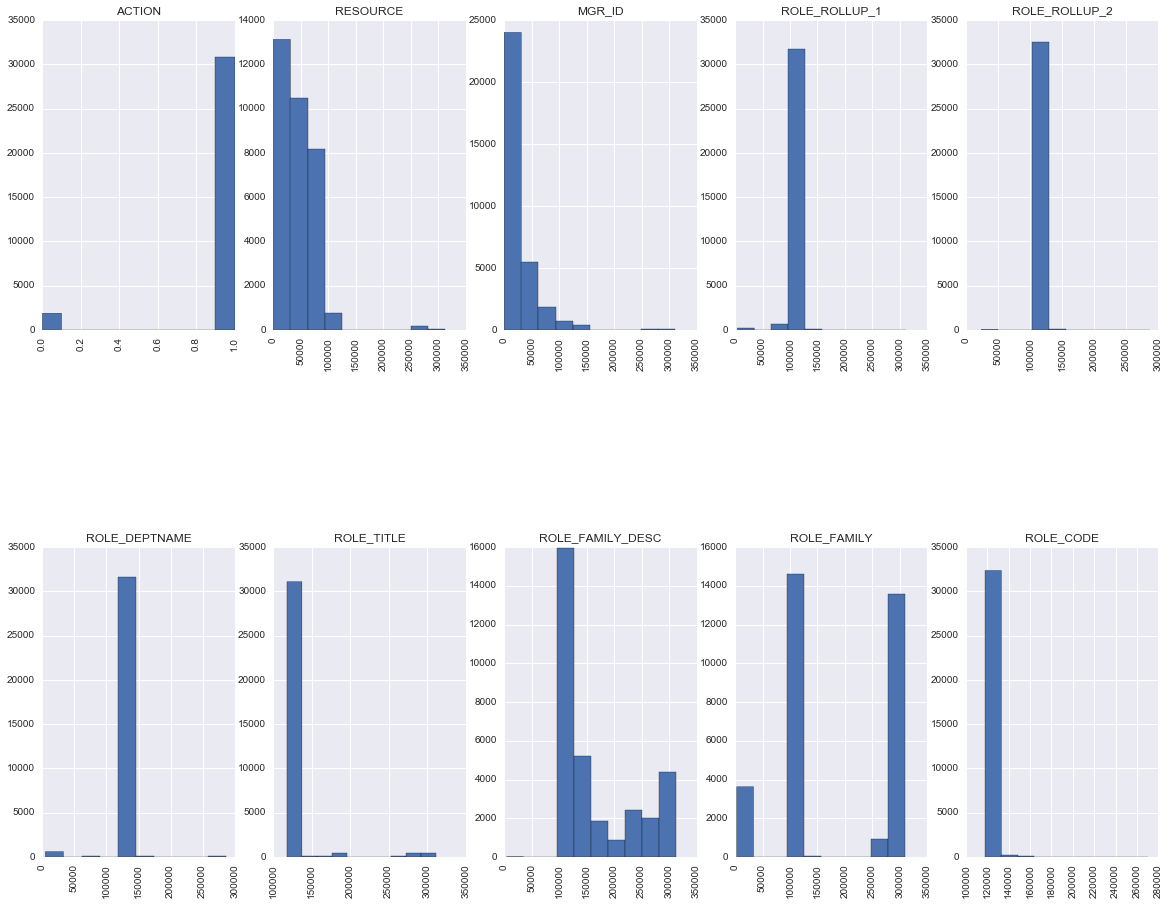

In [3]:
def show_feature_dist(df):
    """ Plot the distribution for each feature. """
    fig = plt.figure(figsize=(20, 15))
    cols = 5
    rows = np.ceil(float(df.shape[1]) / cols)
    for i, column in enumerate(df.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if df.dtypes[column] == np.object:
            df[column].value_counts().plot(
                kind="bar", axes=ax)
        else:
            df[column].hist(axes=ax)
            plt.xticks(rotation="vertical")
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.show()

show_feature_dist(train)

### Well, it looks like we have a very lopsided classification problem here. Out of 32769 instances, a little more than 30000 employees are allowed access, while less than 2500 are denied access. Let's take a closer look:

Number of approved resources: 30872
Number of rejected resources: 1897
Fraction of rejects: 0.05789007903811529


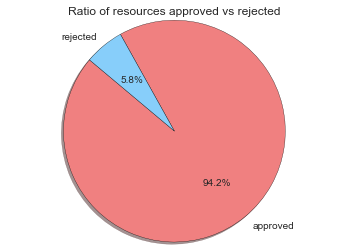

In [4]:
num_approvals = len(y_train[y_train == 1])
num_rejects = len(y_train[y_train == 0])
total = num_approvals + num_rejects

print("Number of approved resources: {}".format(num_approvals))
print("Number of rejected resources: {}".format(num_rejects))
print("Fraction of rejects: {}".format(num_rejects / total))

amounts = [num_approvals, num_rejects]
colors = ['lightcoral', 'lightskyblue']
labels = ['approved', 'rejected']
plt.pie(amounts, labels=labels, colors=colors,
         autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Ratio of resources approved vs rejected')
plt.show()

### What are the different types of features/variables?
- **Categorical**: Has 2 or more discrete categories. Divided into Nominal, Ordinal, and Binary.
    - **Ordinal**: Has 2 or more categories that have an inherent ordering.
        - How good your professor is: [bad, average, good]
        - How much you like ice cream: [ew, its okay, delicious!]
        - Your education level: [high school diploma, associate degree, bachelor's, master's, PhD]
    - **Binary**: Only two different categories. No inherent order.
        - Male, Female
        - Raining, Not Raining
    - **Nominal**: 2 or more categories that have no inherent ordering.
        - States in the USA: [Texas, California, New York, Washington...]
        - Countries in the world: [USA, China, India, Canada...]
- **Continuous**: Values are continuous and have an inherent ordering.
    - Age: 0~125 years
    - Height: 0~84 inches
    - Yearly Income
        
- ### Further reading:
    - http://www.ats.ucla.edu/stat/mult_pkg/whatstat/nominal_ordinal_interval.htm
    - https://statistics.laerd.com/statistical-guides/types-of-variable.php


### Let's  try to better understand what each feature represents:
1. **Resource**: Resource ID. Nominal or ordinal.
2. **MGR_ID**: Manager ID. Nominal or ordinal.
3. **ROLE_ROLLUP_1**: Not sure.
4. **ROLE_ROLLUP_2**: Not sure.


#### Read these links for some interesting food for thought:
- https://www.kaggle.com/c/amazon-employee-access-challenge/forums/t/4840/gbm-code-auc-0-876
- https://www.kaggle.com/c/amazon-employee-access-challenge/forums/t/4735/beating-the-benchmark
- https://www.kaggle.com/c/amazon-employee-access-challenge/forums/t/4838/python-code-to-achieve-0-90-auc-with-logistic-regression
- https://www.kaggle.com/c/amazon-employee-access-challenge/forums/t/5283/winning-solution-code-and-methodology

## Visualize the pairwise correlation b/w variables:

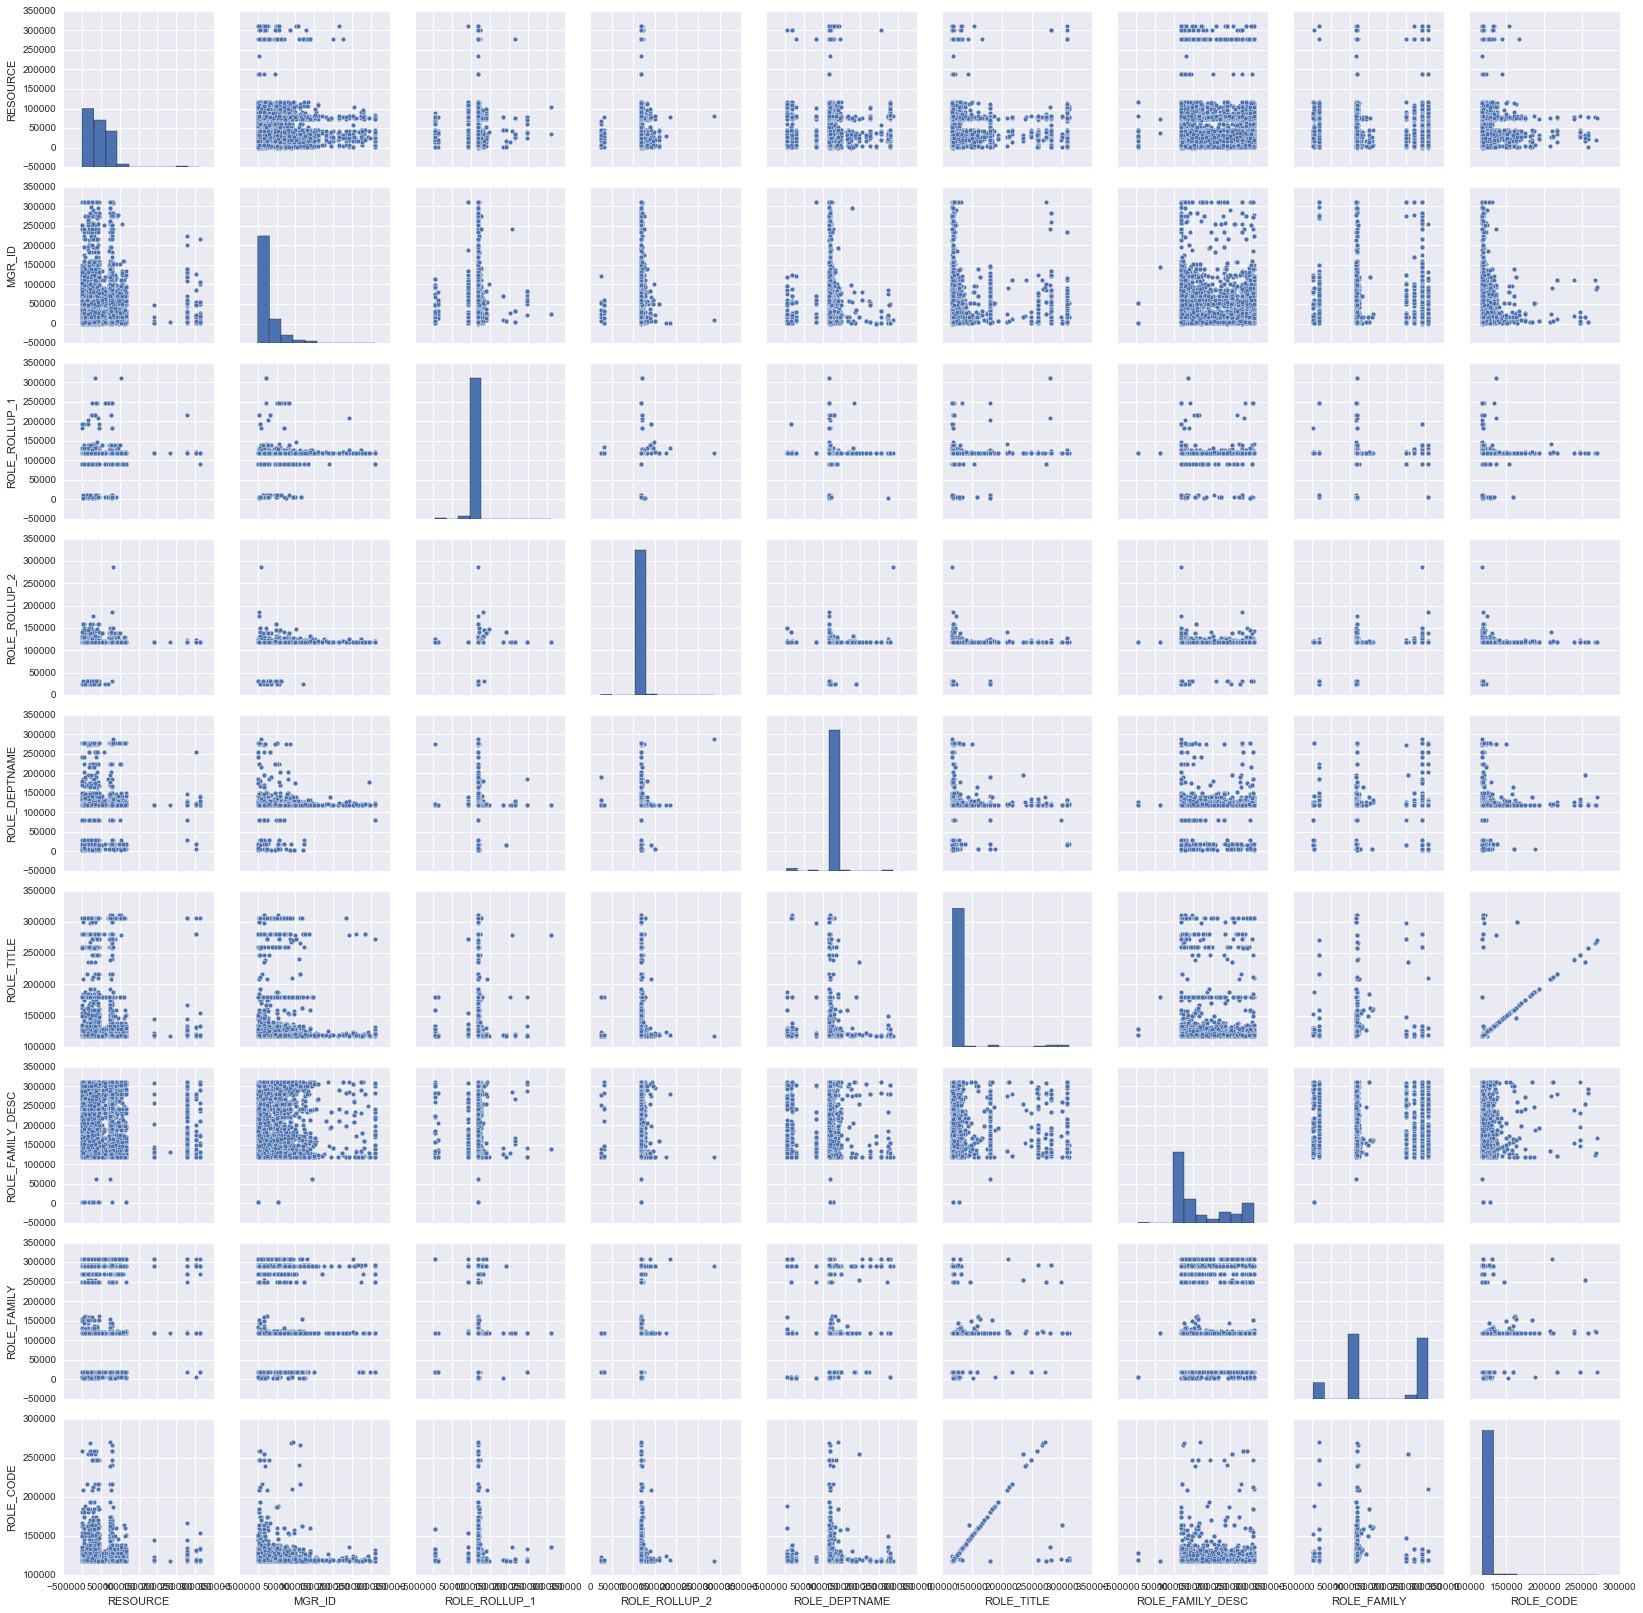

In [5]:
sns.pairplot(X_train)

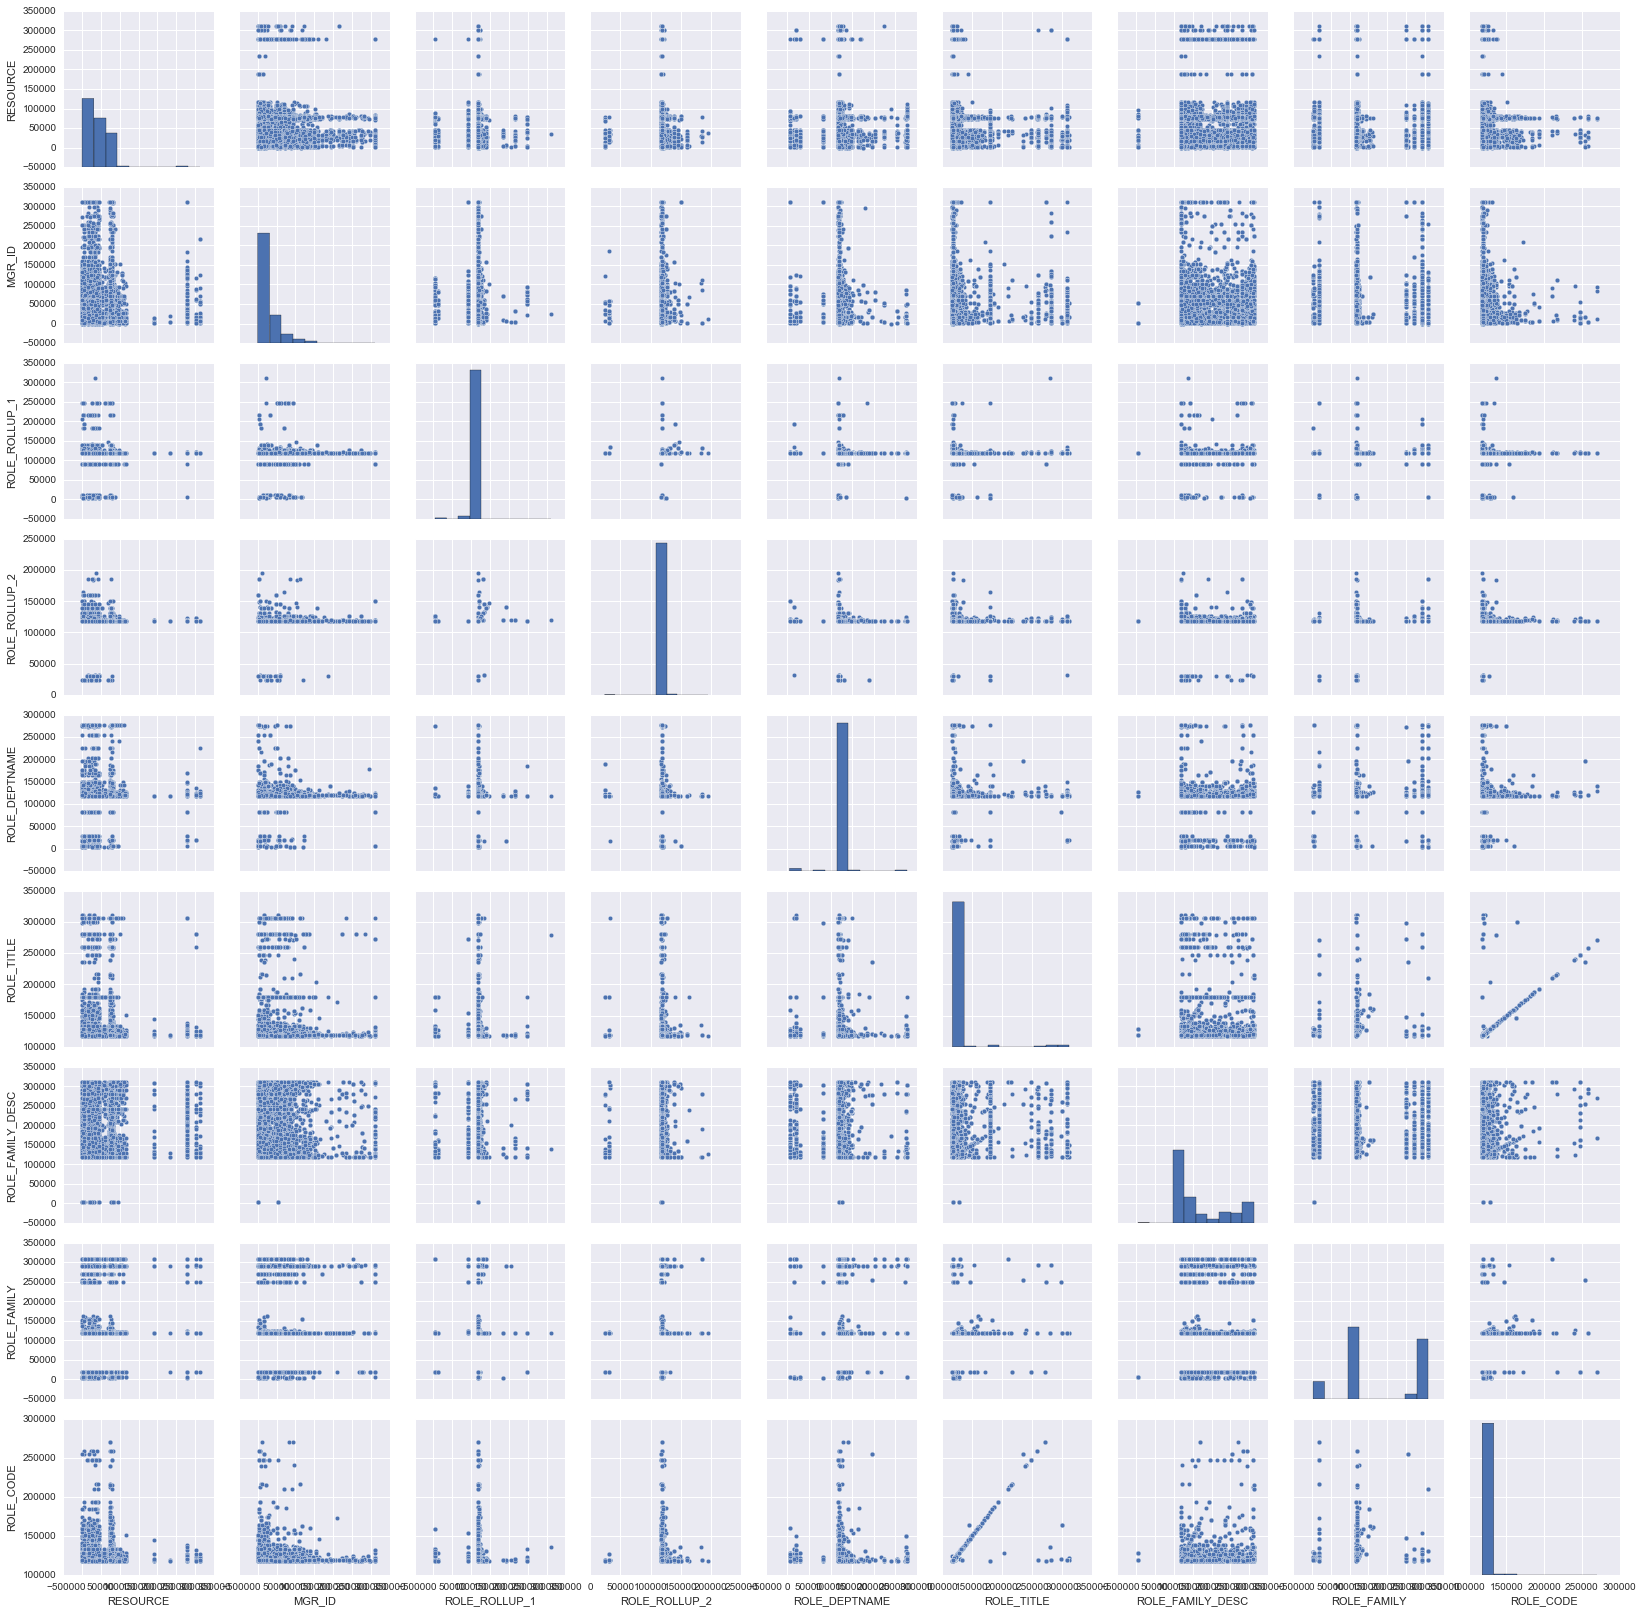

In [6]:
sns.pairplot(test)

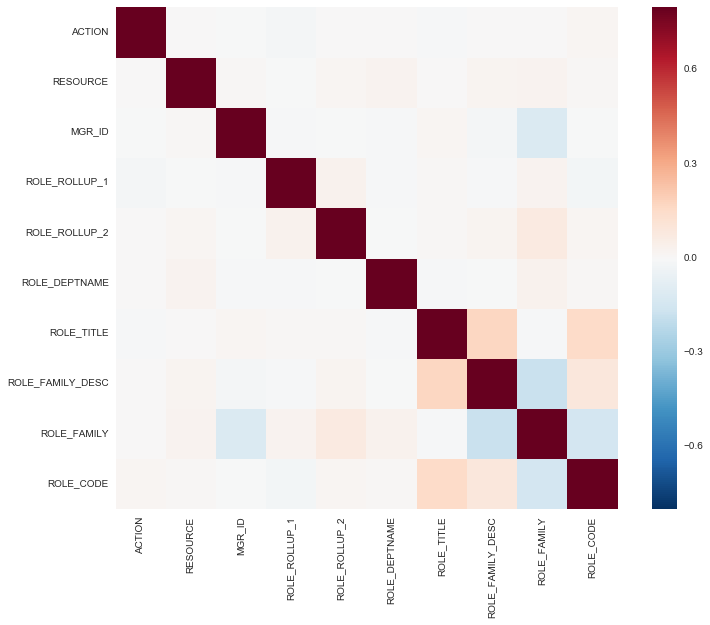

In [7]:
corrmat = train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

## Let's just go ahead and use a naive linear classifier, see how we do.

In [5]:
type(train)
type(test)

display(train.head(5))

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

X_t, X_val, y_t, y_val = train_test_split(
        X_train, y_train, test_size=0.33, random_state=42)

linear_clf = SGDClassifier()
linear_clf.fit(X_t, y_t)
predictions = linear_clf.predict(X_val)


y_val = np.array(y_val)
print(predictions)
print(y_val)

[1 1 1 ..., 1 1 1]
[1 1 1 ..., 1 1 1]


In [7]:
roc_auc_score(y_val, predictions)

0.50040317429903558

### We can't run a naive classification algorithm yet. On the forums for this competition, Kagglers have come to the conclusion that most of features are nominal, not ordinal!

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, max_features='auto')

display(X_train.head(1))
display(y_train.head(1))

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908


0    1
Name: ACTION, dtype: int64

In [ ]:
rf.fit(X_t, y_t)
predictions = rf.predict(X_val)
roc_auc_score(predictions, y_val)

In [10]:
core = cross_val_score(rf, X=X_train, y=np.array(y_train), scoring='roc_auc', cv=5)
print(score)

[ 0.84410143  0.87157767  0.85013329  0.84771914  0.85638707]


In [11]:
score = cross_val_score(rf, X=X_train, y=np.array(y_train), scoring='roc_auc', cv=10)
print(score)

[ 0.85055478  0.8485828   0.88474503  0.86105826  0.85527339  0.85487528
  0.84757387  0.86416839  0.87926755  0.8474384 ]


In [22]:
print(score.mean())
print(score.std())

0.859353774395
0.01256282315


In [55]:
clf = RandomForestClassifier(criterion='entropy', n_estimators=2000)
clf.fit(X_train, y_train)

# Spit out predictions to a file
rf_best_predictions = clf.predict(test)
tally_predictions(rf_best_predictions)
rf_pred_write = enumerate(rf_best_predictions, start=1)
with open('output/rf_2ktrees_entropy_auto_boostrapped.csv', 'w') as f:
    f.write('Id,Action\n')
    for instance, prediction in rf_pred_write:
        f.write('{},{}\n'.format(instance, prediction))

2181
56740


# Random forest doesn't necessarily overfit. Check it out.

In [44]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', bootstrap=True)
score = cross_val_score(rf, X=X_train, y=np.array(y_train), scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
rf.fit(X_train, y_train)
predictions = rf.predict(test)
print(score.mean())
print(score.std())
tally_predictions(predictions)

[ 0.85604973  0.84837145  0.8859257   0.86375377  0.85684875  0.85846078
  0.84635313  0.86850558  0.88146914  0.85537833]
0.862111637059
0.0124323592715
2251
56670


In [45]:
rf_pred_write = enumerate(predictions, start=1)
with open('output/rf_1ktrees_gini_auto_bootstrapped.csv', 'w') as f:
    f.write('Id,Action\n')
    for instance, prediction in rf_pred_write:
        f.write('{},{}\n'.format(instance, prediction))

In [10]:
rf = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_features='auto', bootstrap=True)
score = cross_val_score(rf, X=X_train, y=np.array(y_train), scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
rf.fit(X_train, y_train)
predictions = rf.predict_proba(test)
print(score.mean())
print(score.std())
# tally_predictions(predictions)

[ 0.85457629  0.84709146  0.8838397   0.86873817  0.85662967  0.86057491
  0.84903074  0.86424466  0.8808264   0.85069664]
0.861624864551
0.0121846435692


In [12]:
rf_pred_write = enumerate(predictions, start=1)
with open('output/rf_1ktrees_entropy_auto_bootstrapped.csv', 'w') as f:
    f.write('Id,Action\n')
    for instance, prediction in rf_pred_write:
        f.write('{},{}\n'.format(instance, prediction[1]))

## Things to try:
Get rid of some of the features, like the winners said

In [28]:
display(test.head(5))
X_train = X_train.drop(["ROLE_ROLLUP_1", "ROLE_ROLLUP_2"], axis=1)
test = test.drop(["ROLE_ROLLUP_1", "ROLE_ROLLUP_2"], axis=1)

,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
id,,,,,,,
1,78766,72734,117878,117879,118177,19721,117880
2,40644,4378,118507,118863,122008,118398,118865
3,75443,2395,119488,118172,301534,249618,118175
4,43219,19986,118403,120773,136187,118960,120774
5,42093,50015,119598,118422,300136,118424,118425


ValueError: labels ['ROLE_ROLLUP_1' 'ROLE_ROLLUP_2'] not contained in axis

In [32]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', bootstrap=False)
score = cross_val_score(rf, X=X_train, y=np.array(y_train), scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
rf.fit(X_train, y_train)
predictions = rf.predict(test)
print(predictions)

[ 0.7839685   0.78845105  0.81611682  0.80220108  0.78671423  0.79338994
  0.7838218   0.80407855  0.81444374  0.79736752]
[1 1 1 ..., 1 0 1]


In [34]:
rf_pred_write = enumerate(predictions, start=1)
with open('output/rf_1ktrees_gini_auto_nobootstrap.csv', 'w') as f:
    for instance, prediction in rf_pred_write:
        f.write('{},{}\n'.format(instance, prediction))

In [35]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', bootstrap=True)
score = cross_val_score(rf, X=X_train, y=np.array(y_train), scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
rf.fit(X_train, y_train)
predictions = rf.predict(test)
print(predictions)

[ 0.84705907  0.83422246  0.88209469  0.86786524  0.84121017  0.86278366
  0.83930745  0.8576022   0.873075    0.85126568]
[1 1 1 ..., 1 1 1]


In [36]:
rf_pred_write = enumerate(predictions, start=1)
with open('output/rf_1ktrees_gini_auto_bootstrapped.csv', 'w') as f:
    f.write('Id,Action\n')
    for instance, prediction in rf_pred_write:
        f.write('{},{}\n'.format(instance, prediction))

In [52]:
param_grid = [
    {'criterion': ['gini', 'entropy'],
    'n_estimators': [1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False] },
]

cv = 10
clf = GridSearchCV(RandomForestClassifier(),
                   param_grid=param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')
clf.fit(X_train, y_train)
print("Best parameter set found on development set with cv={}:\n"
      .format(cv))
print(clf.best_params_)
print()
score = clf.score(X_val, y_val)
print("Test score for these parameters: {}".format(score))
for params, mean_score, scores in clf.grid_scores_:
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(
          mean_score, scores.std() * 2, params))
print()

Best parameter set found on development set with cv=10:

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 1000, 'bootstrap': True}



/home/aetherzephyr/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Test score for these parameters: 1.0
0.861 (+/-0.026) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000, 'bootstrap': True}
0.862 (+/-0.026) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000, 'bootstrap': True}
0.862 (+/-0.026) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000, 'bootstrap': True}
0.862 (+/-0.026) for {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 1000, 'bootstrap': True}
0.863 (+/-0.025) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000, 'bootstrap': True}
0.863 (+/-0.025) for {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 1000, 'bootstrap': True}
0.809 (+/-0.034) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 1000, 'bootstrap': False}
0.809 (+/-0.031) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 1000, 'bootstrap': False}
0.811 (+/-0.031) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 1000,

In [53]:
param_grid = [
    {'criterion': ['entropy'],
    'n_estimators': [2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True] },
]

cv = 10
clf = GridSearchCV(RandomForestClassifier(),
                   param_grid=param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')
clf.fit(X_train, y_train)
print("Best parameter set found on development set with cv={}:\n"
      .format(cv))
print(clf.best_params_)
print()
score = clf.score(X_val, y_val)
print("Test score for these parameters: {}".format(score))
for params, mean_score, scores in clf.grid_scores_:
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(
          mean_score, scores.std() * 2, params))
print()

Best parameter set found on development set with cv=10:

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 2000, 'bootstrap': True}



/home/aetherzephyr/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


Test score for these parameters: 1.0
0.864 (+/-0.025) for {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 2000, 'bootstrap': True}
0.863 (+/-0.025) for {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 2000, 'bootstrap': True}
0.863 (+/-0.026) for {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 2000, 'bootstrap': True}



<Container object of 9 artists>

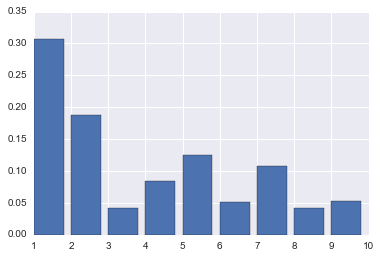

In [69]:
# Most important features?
feature_indices = range(1, 10) # features 1~9
feature_importances = clf.best_estimator_.feature_importances_
plt.bar(feature_indices, feature_importances)

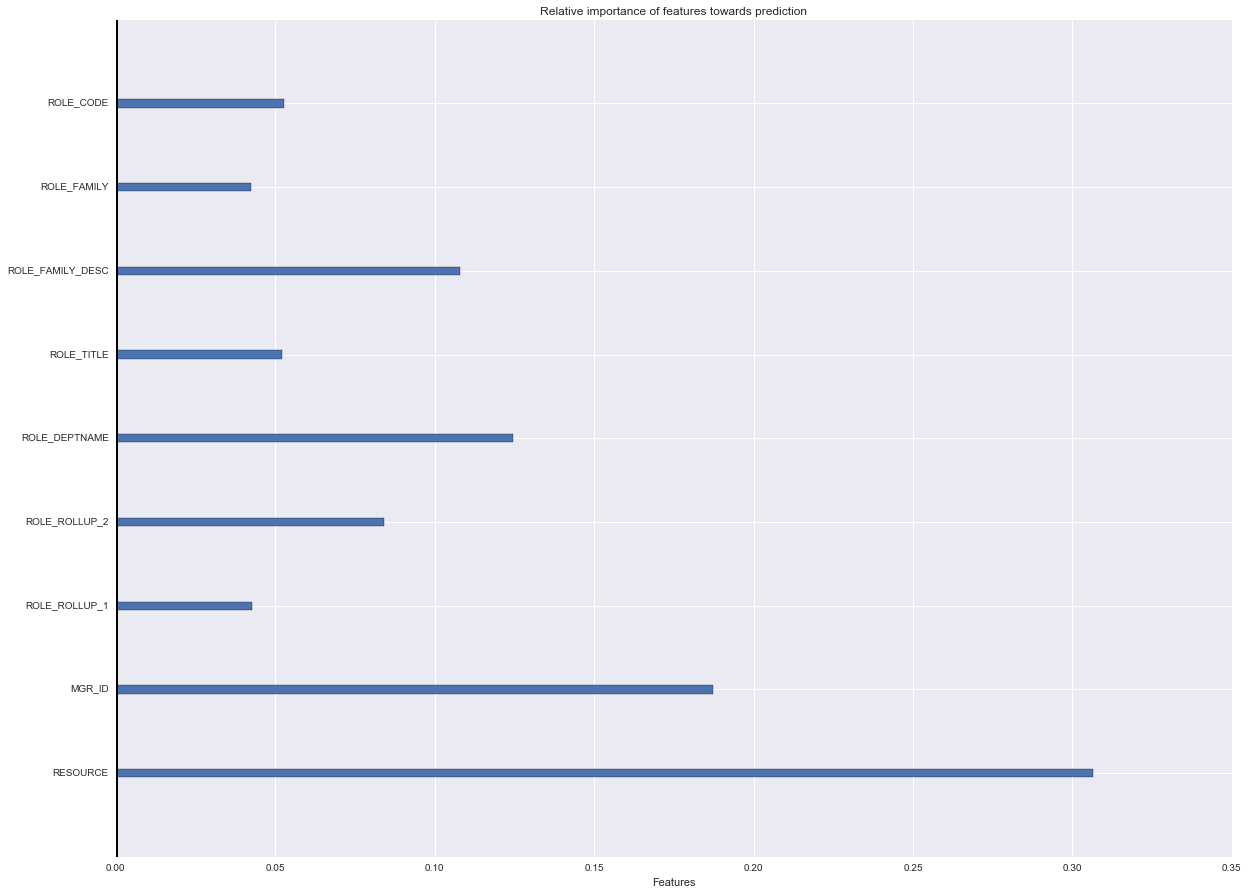

In [71]:
# Got help from here: http://stackoverflow.com/questions/9626298/matplotlib-chart-creating-horizontal-bar-chart
# I needed to plot a horizontal bar chart, not a vertical one.

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111)
ax.barh(feature_indices, feature_importances, align='center',height=0.1)
# Plot feature names instead of indices.
ax.set_yticks(feature_indices)
ax.set_yticklabels(train.columns.values[1:])
ax.axvline(0, color='k', lw=3)   # poor man's zero level

ax.set_xlabel('Features')
ax.set_title('Relative importance of features towards prediction')
ax.grid(True)
plt.show()

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import RandomizedSearchCV

param_grid = [
    {'n_estimators': [1000],
     'learning_rate': [0.1, 1],
    },
]

cv = 10
ab_clf = GridSearchCV(AdaBoostClassifier(),
                   param_grid=param_grid, cv=cv, n_jobs=-1, scoring='roc_auc')
ab_clf.fit(X_train, y_train)
print("Best parameter set found on development set with cv={}:\n"
      .format(cv))
print(ab_clf.best_params_)
print()
for params, mean_score, scores in ab_clf.grid_scores_:
    print("{0:.3f} (+/-{1:.03f}) for {2}".format(
          mean_score, scores.std() * 2, params))
print()

Best parameter set found on development set with cv=10:

{'learning_rate': 1, 'n_estimators': 1000}

Test score for these parameters: [ 0.85569096  0.84905065  0.89022556  0.86630266  0.85937889  0.86172319
  0.85251479  0.86438178  0.88212302  0.8552335 ]
0.715 (+/-0.032) for {'learning_rate': 0.1, 'n_estimators': 1000}
0.769 (+/-0.030) for {'learning_rate': 1, 'n_estimators': 1000}



In [51]:
predictions = ab_clf.predict(test)
tally_predictions(predictions)

46
58875


In [53]:
# Spit out predictions to a file
pred_write = enumerate(predictions, start=1)
with open('output/adaboost_1ktrees_learn1.csv', 'w') as f:
    f.write('Id,Action\n')
    for instance, prediction in pred_write:
        f.write('{},{}\n'.format(instance, prediction))